# Assignment 1
# Sparse Bayesian Neural Networks using Automatic Relevance Determination

Variational Dropout ([arXiv:1506.02557](https://arxiv.org/abs/1506.02557)) provides a Bayesian interpretation of the conventional dropout procedure. Later it was shown that Variational Dropout can be used for model sparsification (Sparse VD), an the effect can be achieved via optimization of variational lower bound wrt individual dropout rates for every weight of the model ([arXiv:1701.05369](https://arxiv.org/abs/1701.05369)).

In this assignment we would consider another interpretation of this model that uses the *Automatic Relevance Determination* (ARD) prior. This model is described in [arXiv:1811.00596](https://arxiv.org/abs/1811.00596).

#### ARD BNN

The ARD BNN model optimizes the evidence lower bound (ELBO) $\mathcal{L}(\phi)$ with respect to parameters $\phi$ of a variational approximation $q_\phi(w)$:

$$\mathcal{L}(\phi) =  L_\mathcal{D}(\phi) - D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2)) \to\max_{\phi, \lambda^2},$$
$$L_\mathcal{D}(\phi) = \sum_{n=1}^N \mathrm{E}_{q_\phi(w)}[\log p(y_n\,|\,x_n, w)],$$
$$p(w_{ij}\,|\,\lambda^2_{ij})=\mathcal{N}(w_{ij}\,|\,0,\lambda^2_{ij})\text{ is the ARD prior,}$$

$$q_\phi(w_{ij}) = \mathcal{N}(w_{ij}\,|\,\mu_{ij},\sigma^2_{ij})\text{ is the fully-factorized Gaussian posterior approximation},$$

and the log-likelihood $p(y\,|\,x, w)$ is defined by a neural network with parametrs $w$ using a conventional cross-entropy loss function. The optimization is performed by stochasic optimization methods. Adam with default hyperparameters and a simple multi step LR schedule should work fine.

The optimization w.r.t. the prior variance $\lambda^2$ can be performed analytically; the optimal value is $\lambda_{ij}^2=\mu_{ij}^2+\sigma_{ij}^2$. The KL-divergence term then becomes equal to:

$$D_{KL}(q_\phi(w)\,\|\,p(w\,|\,\lambda^2))=\frac12\sum_{ij}\log(1+\frac{\mu_{ij}^2}{\sigma_{ij}^2}).$$

**Note:** You will need to refer to the value $\log\alpha_{ij}=\log\frac{\sigma_{ij}^2}{\mu_{ij}^2}$ in order to determine which weights to zero out. It is also convenient to use it to compute the KL divergence. A rule of thumb is to zero out all the weights that have $\log\alpha_{ij}>3$, but you can use another threshold.

**Note:** Optimize w.r.t. $\log\sigma$ instead of $\sigma$ to better represent small values of $\sigma$.

**Note:** Some of the operations (e.g. log and square root) can be unstable for small arguments. In order to avoid NaNs, you can add a "safe" modification: just add a small constant (e.g. `1e-8`) to the argument and / or use appropriate clamping.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/bd8c169c6b162dac5aa77013d70463eae0927c5e/images/svd3.png)


# In this assignment:
1. Implementation of fully-connected ARD Layer
2. Training Lenet-300-100 on MNIST dataset (test accuracy should be $\geq 98.1$)
3. Optional Research Assignment

Additional information:
- If you have a problem with importing logger, download logger.py and file to the same folder and run a notebook from it
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib), tabulate
- If you have an urgent question or find a typo or a mistake, text it to Alexander Grishin in Discord

In [2]:
import math
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Parameter
from torchvision import datasets, transforms

from logger import Logger

## Implementation of  the Linear ARD layer

In [3]:
class LinearARD(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearARD, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.mu = torch.nn.Parameter(torch.zeros(self.out_features, self.in_features))
        self.log_sigma = torch.nn.Parameter(torch.zeros(self.out_features, self.in_features))
        self.bias = torch.nn.Parameter(torch.zeros(1, self.out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x):      
        # x is a torch.Tensor of shape (number_of_objects, in_features)
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        self.log_alpha = 2 * (self.log_sigma - torch.log(torch.abs(self.mu) + 1e-8))
        # clipping for a numerical stability
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)   
        
        if self.training:
            # LRT = local reparametrization trick
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_mean =  F.linear(x, self.mu, bias=self.bias).to(device)
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_std = torch.sqrt(F.linear(x ** 2, (torch.exp(self.log_sigma)) ** 2) + 1e-8).to(device)
            # eps is a torch.Tensor of shape (x.shape[0], out_features)
            eps = torch.normal(0, 1, size=lrt_mean.shape).to(device)
            return lrt_mean + eps * lrt_std
       
        out = F.linear(x, self.mu * (self.log_alpha <= self.threshold).float(), self.bias).to(device)
        # use weights W = E q = self.mu
        # clip all weight with log_alpha > threshold
        return out
        
    def kl_reg(self):
        # kl is a scalar torch.Tensor 
        kl = 0.5 * torch.sum(torch.log1p(torch.exp(-self.log_alpha)))
        return kl

## Define LeNet-300-100

In [4]:
class Net(nn.Module):
    def __init__(self, threshold):  
        super(Net, self).__init__()
        self.fc1 = LinearARD(28*28, 300, threshold)
        self.fc2 = LinearARD(300,  100, threshold)
        self.fc3 = LinearARD(100,  10, threshold)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

## Function for loading MNIST

In [5]:
def get_mnist(batch_size):
    trsnform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
        transform=trsnform), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## Define the ELBO loss function

In [6]:
class ELBO(nn.Module):
    def __init__(self, net, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size # int, the len of dataset
        self.net = net # nn.Module
        
    def forward(self, input, target, kl_weight=1.0):
        """
          input: is a torch.Tensor (a predictions of the model) 
          target: is a torch.Tensor (a tensor of labels) 
        """
        assert not target.requires_grad
        kl = 0.0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
                
        elbo_loss = F.cross_entropy(input, target, reduction='mean') * self.train_size + kl_weight * kl
        return elbo_loss

## Define the model

In [7]:
model = Net(threshold=3)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75])

logger = Logger('ard', fmt={
    'tr_loss': '3.1e',
    'te_loss': '3.1e',
    'sp_0':    '.3f',
    'sp_1':    '.3f',
    'sp_2':    '.3f',
    'lr':      '3.1e',
    'kl':      '.2f',
    'time':    '.2f',
})

train_loader, test_loader = get_mnist(batch_size=100)
elbo = ELBO(model, len(train_loader.dataset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Train the model

In [ ]:
# Switch the device to cuda to reduce one epoch from ~30 sec to ~10 sec

device = 'cpu'
# device = 'cuda:0'

model = model.to(device)
elbo = elbo.to(device)

kl_weight = 0.02
epochs = 100

for epoch in range(1, epochs + 1):
    time_start = time.perf_counter()
    scheduler.step()
    model.train()
    train_loss, train_acc = 0, 0 
    kl_weight = min(kl_weight+0.02, 1)
    logger.add_scalar(epoch, 'kl', kl_weight)
    logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        data = data.view(-1, 28*28)
        optimizer.zero_grad()
        
        output = model(data)
        pred = output.data.max(1)[1] 
        loss = elbo(output, target, kl_weight)
        loss.backward()
        optimizer.step()
        
        train_loss += float(loss) 
        train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

    logger.add_scalar(epoch, 'tr_loss', train_loss / len(train_loader.dataset))
    logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(elbo(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
        
    logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
    logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
    
    for i, c in enumerate(model.children()):
        if hasattr(c, 'kl_reg'):
            logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.cpu().numpy() > model.threshold).mean())
    
    logger.add_scalar(epoch, 'time', time.perf_counter() - time_start)
    logger.iter_info()

  epoch    kl       lr    tr_loss    tr_acc    te_loss    te_acc    sp_0    sp_1    sp_2    time
-------  ----  -------  ---------  --------  ---------  --------  ------  ------  ------  ------
      1  0.04  1.0e-03    2.5e+02      91.2    1.3e+02      95.9   0.345   0.174   0.053   31.42
      2  0.06  1.0e-03    1.3e+02      96.6    1.0e+02      97.4   0.459   0.243   0.079   30.71
      3  0.08  1.0e-03    1.1e+02      97.4    1.0e+02      97.3   0.535   0.302   0.089   31.29
      4  0.10  1.0e-03    9.4e+01      97.8    8.9e+01      97.8   0.599   0.375   0.099   30.48
      5  0.12  1.0e-03    8.6e+01      98.0    9.1e+01      97.7   0.660   0.423   0.129   31.13
      6  0.14  1.0e-03    8.1e+01      98.2    8.5e+01      97.9   0.719   0.459   0.115   30.95
      7  0.16  1.0e-03    7.9e+01      98.3    8.5e+01      97.9   0.743   0.488   0.113   31.54
      8  0.18  1.0e-03    7.6e+01      98.3    7.9e+01      98.2   0.769   0.523   0.139   31.37
      9  0.20  1.0e-03    7.6e

In [ ]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.cpu().numpy().size

# compression_ratio should be > 25
compression_ratio = all_w/kep_w
print('compression_ratio =', compression_ratio)
assert compression_ratio >= 25

compression_ratio = 36.58603628367235


## Disk space

In [ ]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].mu.data.cpu().numpy()
LA = list(model.children())[0].log_alpha.data.cpu().numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [ ]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [ ]:
!ls -lah | grep .npz 

-rw-r--r-- 1 root root  29K Mar 10 10:46 Mcoo_w.npz
-rw-r--r-- 1 root root  28K Mar 10 10:46 Mcsc_w.npz
-rw-r--r-- 1 root root  28K Mar 10 10:46 Mcsr_w.npz
-rw-r--r-- 1 root root 815K Mar 10 10:46 M_w.npz


## Visualization

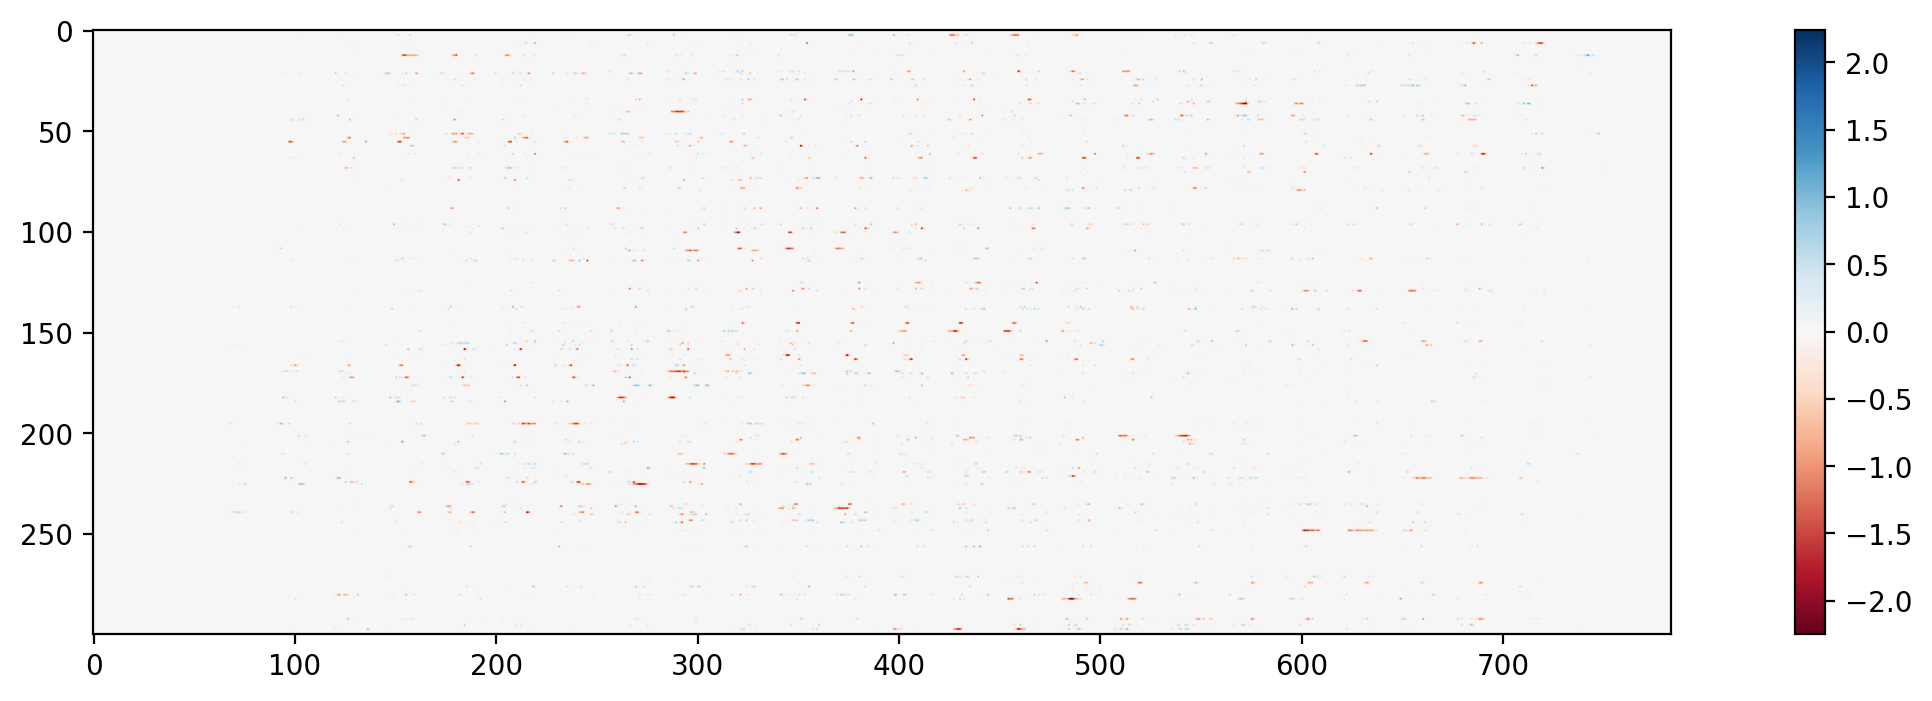

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 4
rcParams['figure.dpi'] = 200


mask = (model.fc1.log_alpha.detach().cpu().numpy() < 3).astype(float)
W = model.fc1.mu.detach().cpu().numpy()

# Normalize color map
max_val = np.max(np.abs(mask * W))
norm = mpl.colors.Normalize(vmin=-max_val,vmax=max_val)

plt.imshow(mask * W, cmap='RdBu', interpolation=None, norm=norm)
plt.colorbar()

(-0.5, 419.5, 419.5, -0.5)

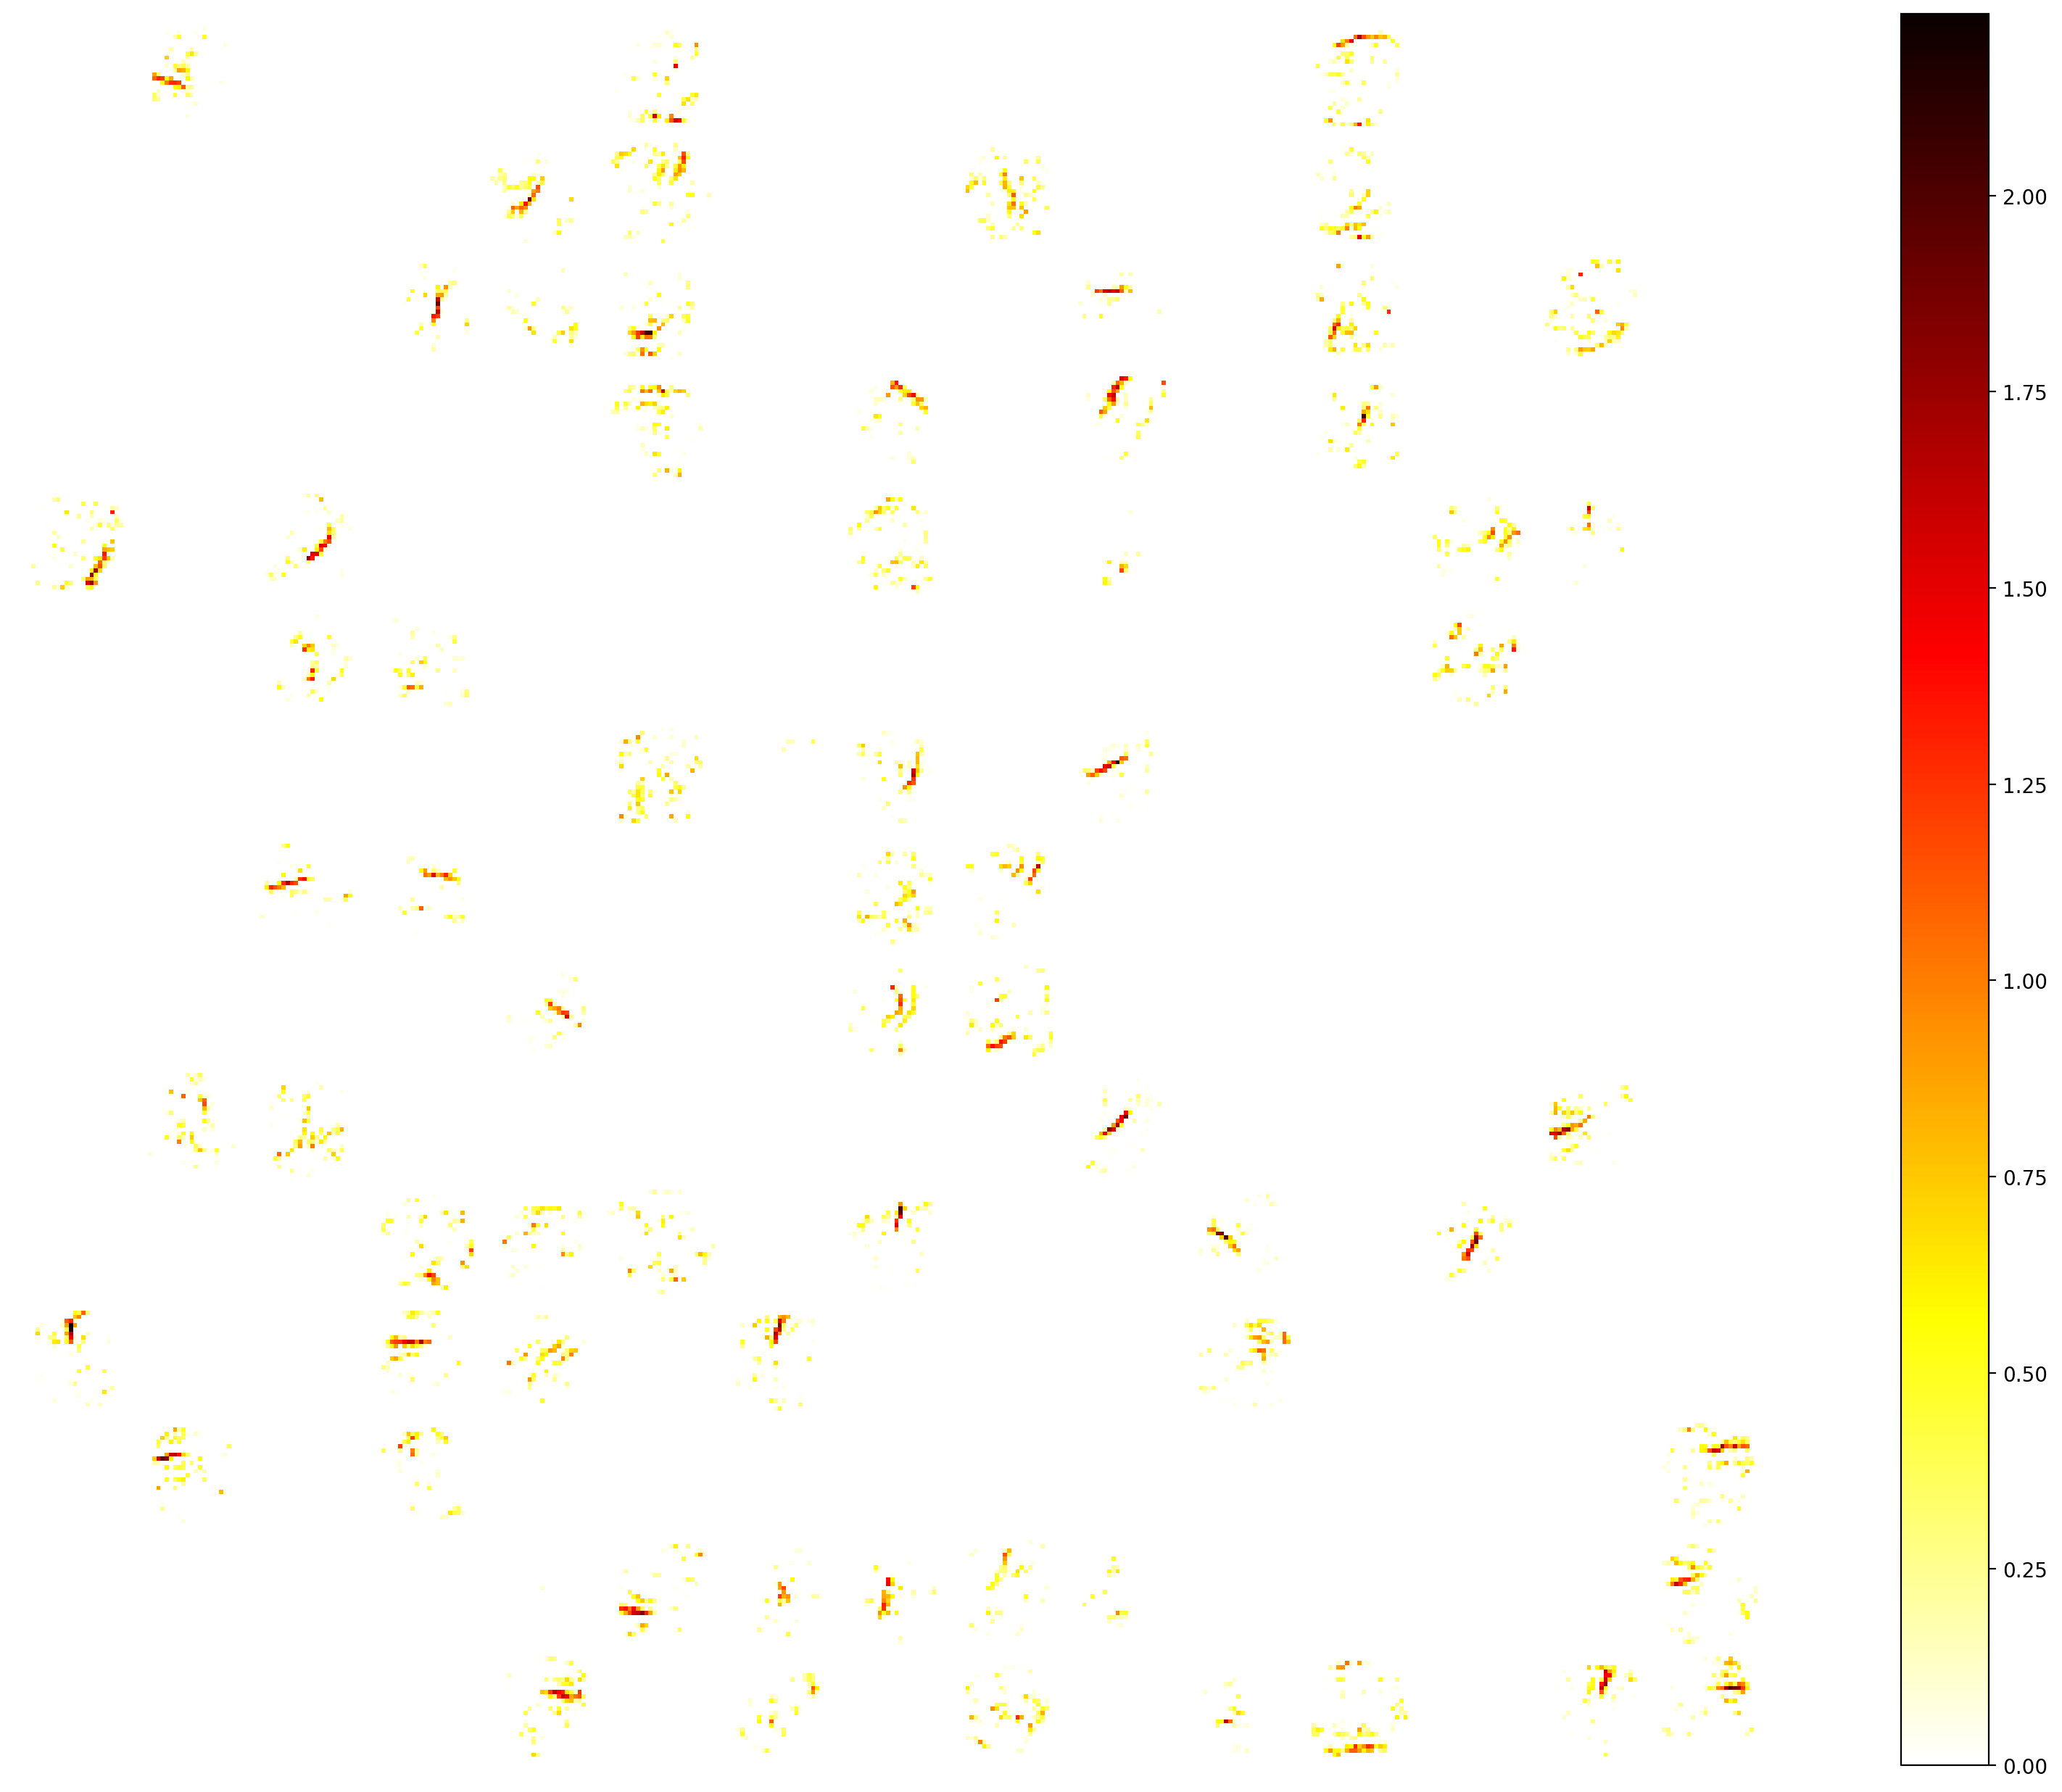

In [ ]:
s = 0
z = np.zeros((28*15, 28*15))

for i in range(15):
    for j in range(15):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] = np.abs((mask * W)[s].reshape(28, 28))

plt.figure(figsize=(24, 16))
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')

# Optional Research Assignment (up to 2 additional points)

1. Study the model: 
    - How sparsity and accuracy depend on maximum of KL-multiplier (kl_weight)?
    - How sparsity and accuracy depend on the initialization?
    - Study the KL: what if we optimize w.r.t. $\lambda^{2}$ using Adam instead of substituting the optimal $\lambda^2$?
    - How does the behaviour of optimization change if you use another parameterization for the approximate posterior? How does it affect the variance of the stochastic gradients?
2. Compression:
    - What can we do to obtain better compression results with small quality degradation?
    - Propose and eval several options.
3. Study the Local reparametrization trick: 
    - Does it really accelerate convergence?
    - Does variance of gradient decrease?
    
You can do one out of three parts. You need to provide evidence for results e.g., plots, etc.

Consider compression of network weights. As the simplest approach, we can consider reducing the threshold for the layer to zero more weights. Сonsider the threshold values less than the recommended value of 3.

In [ ]:
import pandas as pd
threshold_values = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
thr_res = []

for threshold in threshold_values:

    model = Net(threshold=threshold)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75])


    train_loader, test_loader = get_mnist(batch_size=100)
    elbo = ELBO(model, len(train_loader.dataset))
    device = 'cpu'
    #device = 'cuda'

    model = model.to(device)
    elbo = elbo.to(device)
    kl_weight = 0.02
    epochs = 100

    for epoch in range(1, epochs + 1):
        scheduler.step()
        model.train()
        train_loss, train_acc = 0, 0 
        kl_weight = min(kl_weight+0.02, 1)
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()
            output = model(data)
            pred = output.data.max(1)[1] 
            loss = elbo(output, target, kl_weight)
            loss.backward()
            optimizer.step()
        
            train_loss += float(loss) 
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(elbo(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset) * 100
    all_w, kep_w = 0, 0

    for c in model.children():
        kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
        all_w += c.log_alpha.data.cpu().numpy().size
    compression_ratio = all_w/kep_w
    thr_res.append({'Threshold': threshold, 'Compression ratio': compression_ratio, 'Test accuracy': test_acc})
thr_res = pd.DataFrame.from_records(thr_res)

In [9]:
thr_res

,Threshold,Compression ratio,Test accuracy
0,0.1,74.544945,98.31
1,0.5,63.729950,98.29
2,1.0,58.236710,98.38
3,1.5,53.154952,98.33
4,2.0,48.763510,98.46
5,2.5,41.776522,98.44
6,3.0,36.026526,98.42


Thus, reducing the threshold really allows to significantly increase the compression rate at the cost of minor model quality changes, and in some cases, the accuracy has even slightly increased in comparison with the previously considered threshold value of 3.

Also let's consider the model and how changing maximum of the KL-multiplier will affect the accuracy and sparsity of the model. 

In [ ]:
import pandas as pd
kl_weight_values = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
kl_res = []

for kl_weight in kl_weight_values:

    model = Net(threshold=3)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75])


    train_loader, test_loader = get_mnist(batch_size=100)
    elbo = ELBO(model, len(train_loader.dataset))
    device = 'cpu'
    #device = 'cuda'
    model = model.to(device)
    elbo = elbo.to(device)
    epochs = 100

    for epoch in range(1, epochs + 1):
        scheduler.step()
        model.train()
        train_loss, train_acc = 0, 0 
        kl_weight = min(kl_weight+0.02, 1)
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()
            output = model(data)
            pred = output.data.max(1)[1] 
            loss = elbo(output, target, kl_weight)
            loss.backward()
            optimizer.step()
        
            train_loss += float(loss) 
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(elbo(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset) * 100
    all_w, kep_w = 0, 0

    for c in model.children():
        kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
        all_w += c.log_alpha.data.cpu().numpy().size
    compression_ratio = all_w/kep_w
    kl_res.append({'KL-weight': kl_weight, 'Compression ratio': compression_ratio, 'Test accuracy': test_acc})
kl_res = pd.DataFrame.from_records(kl_res)
kl_res['KL-weight'] = kl_weight_values

In [ ]:
kl_res

,KL-weight,Compression ratio,Test accuracy
0,0.01,34.770115,98.44
1,0.02,34.643415,98.48
2,0.05,39.402013,98.36
3,0.10,40.865827,98.35
4,0.25,45.434374,98.29
5,0.50,47.400285,98.21
6,0.75,53.669355,98.06
7,1.00,55.900882,98.07


In general, increasing the maximum KL-multiplier allows to achieve much more noticeable compression with a slight drop in quality: with an increase in compression by about 20 percents, the accuracy on the test data decreased by only 0.4%.

Let's now consider the issue of initialization, let's try to change the variance in $\mu$ initialization.

In [8]:
class LinearARD_custom(nn.Module):
    def __init__(self, in_features, out_features, threshold, mu_var, bias=True):
        super(LinearARD_custom, self).__init__()
        """
            in_features: int, a number of input features
            out_features: int, a number of neurons
            threshold: float, a threshold for clipping weights
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.mu = torch.nn.Parameter(torch.zeros(self.out_features, self.in_features))
        self.log_sigma = torch.nn.Parameter(torch.zeros(self.out_features, self.in_features))
        self.bias = torch.nn.Parameter(torch.zeros(1, self.out_features))
        self.mu_var = mu_var
        self.reset_parameters()
        
    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, self.mu_var)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x):      
        # x is a torch.Tensor of shape (number_of_objects, in_features)
        # log_alpha is a torch.Tensor of shape (out_features, in_features)
        self.log_alpha = 2 * (self.log_sigma - torch.log(torch.abs(self.mu) + 1e-8))
        # clipping for a numerical stability
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)   
        
        if self.training:
            # LRT = local reparametrization trick
            # lrt_mean is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_mean =  F.linear(x, self.mu, bias=self.bias).to(device)
            # lrt_std is a torch.Tensor of shape (x.shape[0], out_features)
            lrt_std = torch.sqrt(F.linear(x ** 2, (torch.exp(self.log_sigma)) ** 2) + 1e-8).to(device)
            # eps is a torch.Tensor of shape (x.shape[0], out_features)
            eps = torch.normal(0, 1, size=lrt_mean.shape).to(device)
            return lrt_mean + eps * lrt_std
       
        out = F.linear(x, self.mu * (self.log_alpha <= self.threshold ).float(), self.bias).to(device)
        # use weights W = E q = self.mu
        # clip all weight with log_alpha > threshold
        return out
        
    def kl_reg(self):
        # kl is a scalar torch.Tensor 
        kl = 0.5 * torch.sum(torch.log1p(torch.exp(-self.log_alpha)))
        return kl


class Net_custom(nn.Module):
    def __init__(self, threshold, mu_var):  
        super(Net_custom, self).__init__()
        self.fc1 = LinearARD_custom(28*28, 300, threshold, mu_var)
        self.fc2 = LinearARD_custom(300,  100, threshold, mu_var)
        self.fc3 = LinearARD_custom(100,  10, threshold, mu_var)
        self.threshold=threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [ ]:
import pandas as pd
mu_var_values = [0.001, 0.01, 0.02, 0.05, 0.1, 0.25, 0.5]
mu_res = []

for mu_var in mu_var_values:

    model = Net_custom(threshold=3, mu_var=mu_var)
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75])


    train_loader, test_loader = get_mnist(batch_size=100)
    elbo = ELBO(model, len(train_loader.dataset))
    device = 'cpu'
    #device = 'cuda'
    model = model.to(device)
    elbo = elbo.to(device)
    kl_weight = 0.02
    epochs = 100

    for epoch in range(1, epochs + 1):
        scheduler.step()
        model.train()
        train_loss, train_acc = 0, 0 
        kl_weight = min(kl_weight+0.02, 1)
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()
            output = model(data)
            pred = output.data.max(1)[1] 
            loss = elbo(output, target, kl_weight)
            loss.backward()
            optimizer.step()
        
            train_loss += float(loss) 
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())    
    model.eval()
    test_loss, test_acc = 0, 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        data = data.view(-1, 28*28)
        output = model(data)
        test_loss += float(elbo(output, target, kl_weight))
        pred = output.data.max(1)[1] 
        test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset) * 100
    all_w, kep_w = 0, 0

    for c in model.children():
        kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
        all_w += c.log_alpha.data.cpu().numpy().size
    compression_ratio = all_w/kep_w
    mu_res.append({'Mu variance': mu_var, 'Compression ratio': compression_ratio, 'Test accuracy': test_acc})
mu_res = pd.DataFrame.from_records(mu_res)
mu_res['Mu variance'] = mu_var_values

In [22]:
mu_res

,Mu variance,Compression ratio,Test accuracy
0,0.001,34.856619,98.39
1,0.010,35.583478,98.56
2,0.020,37.251609,98.59
3,0.050,32.925170,98.52
4,0.100,26.840089,98.25
6,0.250,16.737928,98.44
7,0.500,2.773061,97.42


The best results in terms of accuracy and compression rate were achieved with the default variance value of 0.02 in the layer code. With a decrease in variance value, compression and quality became slightly worse. As the variance increased, the accuracy also decreased slightly, but the compression percentage decreased significantly. Thus, initialization has a greater effect on the percentage of compression, and it does not affect the quality on test so noticeably.